In [2]:
import ctypes
import numpy as np
import cv2
import PIL.Image

In [3]:
class StructureCamera:
    __SC = ctypes.cdll.LoadLibrary('structure_camera')
    
    __start_camera = __SC["startCamera"]
    __start_camera.restype = ctypes.c_bool
    
    __stop_camera = __SC["stopCamera"]
    __started = False
    
    __last_visible_frame = __SC["lastVisibleFrame"]
    __last_visible_frame.argtypes = [ctypes.POINTER(ctypes.c_uint8)]
    __last_visible_frame.restype = ctypes.c_bool
    VisibleVGA = ctypes.c_uint8*(640*480*3)
    
    __last_depth_frame = __SC["lastDepthFrame"]
    __last_depth_frame.argtypes = [ctypes.POINTER(ctypes.c_float)]
    __last_depth_frame.restype = ctypes.c_bool
    DepthVGA = ctypes.c_float*(640*480)
    DepthSXGA = ctypes.c_float*(1280*960)
    
    __get_visible_exposure = __SC["getVisibleExposure"]
    __get_visible_exposure.restype = ctypes.c_float
    __set_visible_exposure = __SC["setVisibleExposure"]
    __set_visible_exposure.argtypes = [ctypes.c_float]
    
    __get_visible_gain = __SC["getVisibleGain"]
    __get_visible_gain.restype = ctypes.c_float
    __set_visible_gain = __SC["setVisibleGain"]
    __set_visible_gain.argtypes = [ctypes.c_float]
    
    __get_infrared_exposure = __SC["getInfraredExposure"]
    __get_infrared_exposure.restype = ctypes.c_float
    __set_infrared_exposure = __SC["setInfraredExposure"]
    __set_infrared_exposure.argtypes = [ctypes.c_float]
    
    __get_infrared_gain = __SC["getInfraredGain"]
    __get_infrared_gain.restype = ctypes.c_float
    __set_infrared_gain = __SC["setInfraredGain"]
    __set_infrared_gain.argtypes = [ctypes.c_float]
    
    SC_RESOLUTION_VGA = ctypes.c_int.in_dll(__SC, 'SC_RESOLUTION_VGA').value
    SC_RESOLUTION_SXGA = ctypes.c_int.in_dll(__SC, 'SC_RESOLUTION_SXGA').value
    __get_depth_resolution = __SC["getDepthResolution"]
    __get_depth_resolution.restype = ctypes.c_int
    __set_depth_resolution = __SC["setDepthResolution"]
    __set_depth_resolution.argtypes = [ctypes.c_int]
    
    SC_DEPTH_RANGE_VERY_SHORT = ctypes.c_int.in_dll(__SC, 'SC_DEPTH_RANGE_VERY_SHORT').value
    SC_DEPTH_RANGE_SHORT = ctypes.c_int.in_dll(__SC, 'SC_DEPTH_RANGE_SHORT').value
    SC_DEPTH_RANGE_MEDIUM = ctypes.c_int.in_dll(__SC, 'SC_DEPTH_RANGE_MEDIUM').value
    SC_DEPTH_RANGE_LONG = ctypes.c_int.in_dll(__SC, 'SC_DEPTH_RANGE_LONG').value
    SC_DEPTH_RANGE_VERY_LONG = ctypes.c_int.in_dll(__SC, 'SC_DEPTH_RANGE_VERY_LONG').value
    SC_DEPTH_RANGE_HYBRID = ctypes.c_int.in_dll(__SC, 'SC_DEPTH_RANGE_HYBRID').value
    SC_DEPTH_RANGE_DEFAULT = ctypes.c_int.in_dll(__SC, 'SC_DEPTH_RANGE_DEFAULT').value
    __get_depth_range = __SC["getDepthRange"]
    __get_depth_range.restype = ctypes.c_int
    __set_depth_range = __SC["setDepthRange"]
    __set_depth_range.argtypes = [ctypes.c_int]
    
    SC_CALIBRATION_OFF = ctypes.c_int.in_dll(__SC, 'SC_CALIBRATION_OFF').value
    SC_CALIBRATION_ONESHOT = ctypes.c_int.in_dll(__SC, 'SC_CALIBRATION_ONESHOT').value
    SC_CALIBRATION_CONTINUOUS = ctypes.c_int.in_dll(__SC, 'SC_CALIBRATION_CONTINUOUS').value
    __get_calibration_mode = __SC["getCalibrationMode"]
    __get_calibration_mode.restype = ctypes.c_int
    __set_calibration_mode = __SC["setCalibrationMode"]
    __set_calibration_mode.argtypes = [ctypes.c_int]
    
    __get_depth_correction = __SC["getDepthCorrection"]
    __get_depth_correction.restype = ctypes.c_bool
    __set_depth_correction = __SC["setDepthCorrection"]
    __set_depth_correction.argtypes = [ctypes.c_bool]
    
    __get_infrared_auto_exposure = __SC["getInfraredAutoExposure"]
    __get_infrared_auto_exposure.restype = ctypes.c_bool
    __set_infrared_auto_exposure = __SC["setInfraredAutoExposure"]
    __set_infrared_auto_exposure.argtypes = [ctypes.c_bool]
    
    __get_gamma_correction = __SC["getGammaCorrection"]
    __get_gamma_correction.restype = ctypes.c_bool
    __set_gamma_correction = __SC["setGammaCorrection"]
    __set_gamma_correction.argtypes = [ctypes.c_bool]
    
    def __init__(self):
        pass
            
    @property
    def started(self):
        return StructureCamera.__started
    
    def __assert_started(self):
        assert self.started, "Cannot execute this operation when the camera has not been streaming"
    
    def __assert_not_started(self):
        assert not self.started, "Cannot execute this operation when the camera has been streaming"
    
    def start(self):
        self.__assert_not_started()
        StructureCamera.__started = StructureCamera.__start_camera()
        return StructureCamera.__started
    
    def stop(self):
        # self.__assert_started()
        StructureCamera.__started = StructureCamera.__stop_camera()
        
    def last_visible_frame(self):
        self.__assert_started()
        visible_data = StructureCamera.VisibleVGA()
        StructureCamera.__last_visible_frame(ctypes.cast(visible_data, ctypes.POINTER(ctypes.c_uint8)))
        np_visible = np.array(visible_data).reshape((480, 640, 3))
        return np_visible
    
    def last_depth_frame(self):
        if self.depth_resolution == StructureCamera.SC_RESOLUTION_SXGA:
            depth_data = StructureCamera.DepthSXGA()
            data_shape = (960, 1280)
        elif self.depth_resolution == StructureCamera.SC_RESOLUTION_VGA:
            depth_data = StructureCamera.DepthVGA()
            data_shape = (480, 640)
        else:
            raise Exception('not supported resolution')
            
        StructureCamera.__last_depth_frame(ctypes.cast(depth_data, ctypes.POINTER(ctypes.c_float)))
        np_depth = np.array(depth_data)
        np_depth[np.isnan(np_depth)] = 1e4 # suppose inf is at 10 meter far
        np_depth = (np_depth / 1e4).reshape(data_shape) # normalize 0 to 1
        return np_depth        
    
    @property
    def visible_exposure(self):
        return StructureCamera.__get_visible_exposure()
    
    @visible_exposure.setter
    def visible_exposure(self, value):
        StructureCamera.__set_visible_exposure(value)
    
    @property
    def visible_gain(self):
        return StructureCamera.__get_visible_gain()
    
    @visible_gain.setter
    def visible_gain(self, value):
        StructureCamera.__set_visible_gain(value)
    
    @property
    def infrared_exposure(self):
        return StructureCamera.__get_infrared_exposure()
    
    @infrared_exposure.setter
    def infrared_exposure(self, value):
        StructureCamera.__set_infrared_exposure(value)
    
    @property
    def infrared_gain(self):
        return StructureCamera.__get_infrared_gain()
    
    @infrared_gain.setter
    def infrared_gain(self, value):
        StructureCamera.__set_infrared_gain(value)
    
    @property
    def depth_resolution(self):
        return StructureCamera.__get_depth_resolution()
    
    @depth_resolution.setter
    def depth_resolution(self, value):
        self.__assert_not_started()
        StructureCamera.__set_depth_resolution(value)
    
    @property
    def depth_range(self):
        return StructureCamera.__get_depth_range()
    
    @depth_range.setter
    def depth_range(self, value):
        self.__assert_not_started()
        StructureCamera.__set_depth_range(value)
    
    @property
    def calibration_mode(self):
        return StructureCamera.__get_calibration_mode()
    
    @calibration_mode.setter
    def calibration_mode(self, value):
        self.__assert_not_started()
        StructureCamera.__set_calibration_mode(value)
    
    @property
    def depth_correction(self):
        return StructureCamera.__get_depth_correction()
    
    @depth_correction.setter
    def depth_correction(self, value):
        self.__assert_not_started()
        StructureCamera.__set_depth_correction(value)
    
    @property
    def gamma_correction(self):
        return StructureCamera.__get_gamma_correction()
    
    @gamma_correction.setter
    def gamma_correction(self, value):
        self.__assert_not_started()
        StructureCamera.__set_gamma_correction(value)
    
    @property
    def infrared_auto_exposure(self):
        return StructureCamera.__get_infrared_auto_exposure()
    
    @infrared_auto_exposure.setter
    def infrared_auto_exposure(self, value):
        self.__assert_not_started()
        StructureCamera.__set_infrared_auto_exposure(value)

In [27]:
sc = StructureCamera()

In [33]:
sc.depth_correction = True
sc.infrared_auto_exposure = True
sc.start()

True

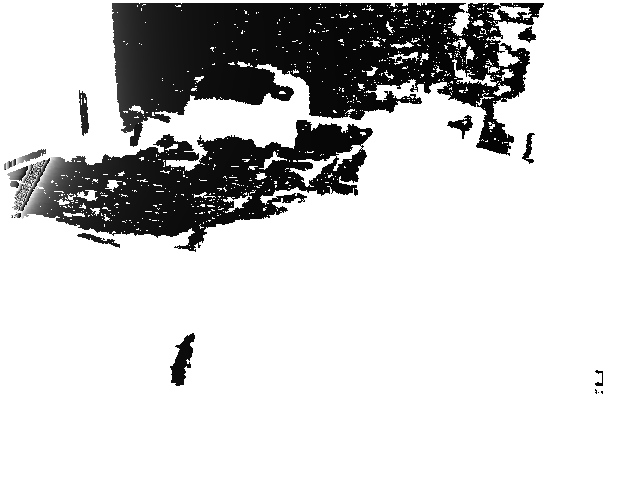

In [52]:
PIL.Image.fromarray((sc.last_depth_frame()*255).astype('uint8'))

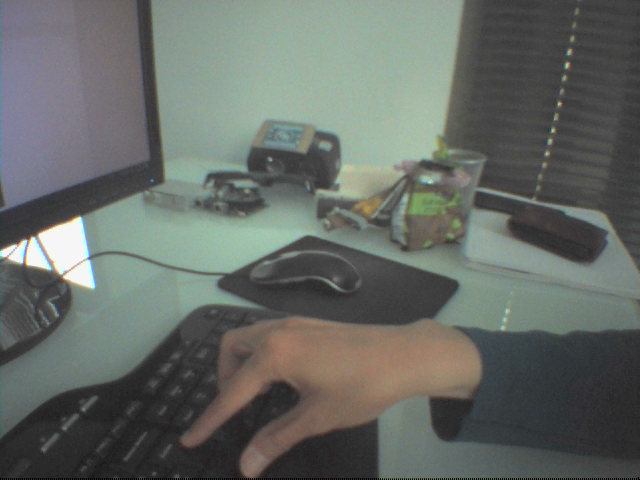

In [51]:
PIL.Image.fromarray(sc.last_visible_frame())

In [53]:
sc.stop()